In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import tensorflow as tf
from tqdm import tqdm
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import time

seed = None
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
sartorius_df = pd.read_csv('../sartorius-cell-instance-segmentation/train.csv')

HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [4]:
def make_mask(image_id, SHAPE=(520, 704)):
    rows = sartorius_df.loc[sartorius_df['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #img = unpad_image(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
get_image_path = lambda image_id: '{}.{}'.format(os.path.join('../sartorius-cell-instance-segmentation/train/', image_id), 'png')

def show_gt_after_stack(image, mask):
    plt.figure(figsize=(10, 10))
    merged = cv2.addWeighted(image, 0.75, 
                             np.clip(np.sum(mask, -1).astype(image.dtype), 0, 1)*255, 0.25, 0.0,)
    plt.imshow(merged, cmap='gray')
    plt.axis('off')
    

def mosaic(image_ids, SHAPE, seed):
    # Split images to stack
    stack_01_ids = image_ids[:2]
    
    # Load image
    stack_01_imgs = [io.imread(get_image_path(image_id)) 
                     for image_id in stack_01_ids]
    
    # Horizontal stack images
    hstack_01 = np.hstack(stack_01_imgs)
    
    # Mosaic mask
    stack_01_masks = [make_mask(image_id) for image_id in stack_01_ids]
        
    mosaic_masks = mosaic_gt(image_ids)
    
    #show_gt_after_stack(hstack_01, mosaic_masks)
    
    mosaic_image, mosaic_masks = random_crop(hstack_01, mosaic_masks, SHAPE, seed)
    
    if mosaic_image.shape[:-1] != SHAPE:
        raise Exception("Does not crop to expected shape")
    
    # After random cropping, the mosaic_masks may has all zero values
    # in random channels, we must remove those channels which contain 
    # all zero values aka. do not contain instances
    mosaic_masks = remove_zero_channel_from_mask(mosaic_masks)
        
    return mosaic_image, mosaic_masks

def mosaic_gt(image_ids):
    # Split images to stack
    stack_01_ids = image_ids[:2]
    
    # Load mask
    stack_01_masks = [make_mask(image_id) for image_id in stack_01_ids]
    
    # First 2 images locate at upper left and right of the mask
    masks_01, masks_02 = stack_01_masks
    
    # Compute total depth aka. total number of instances from 4 masks
    #num_upper_ins = masks_01.shape[-1] + masks_02.shape[-1]
    #num_lower_ins = masks_03.shape[-1] + masks_04.shape[-1]
    #num_ins = num_upper_ins + num_lower_ins
    num_ins = masks_01.shape[-1] + masks_02.shape[-1]
    #print('Total ins before crop: ', num_ins)
    
    # After concatenate, height and width of mask increase twice
    mosaic_mask = np.zeros((HEIGHT, WIDTH*2, num_ins), dtype=np.uint8)
    
    # Upper
    mosaic_mask[:, :WIDTH, :masks_01.shape[-1]] = masks_01
    #print('[0:{}]'.format(masks_01.shape[-1]))
    mosaic_mask[:, WIDTH:, masks_01.shape[-1]:] = masks_02
    #print('[{}:{}]'.format(masks_01.shape[-1], num_upper_ins))
    
    return mosaic_mask

def random_crop(image, mask, expected_shape, seed):    
    if len(image.shape) < 3:
        image = np.expand_dims(image, axis=-1)
    num_image_channels = image.shape[-1]
    
    stacked_image = np.concatenate([image, mask.astype(image.dtype)], axis=-1)
    
    width = expected_shape[1]
    crop_left = np.random.randint(low=0.2*width, high=0.4*width)
    crop_right = width - crop_left
    
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Crop(px=(0, crop_right, 0, crop_left), keep_size=False)
    ])
    
    stacked_image = aug_seq.augment_image(stacked_image)
    
    image = stacked_image[..., :num_image_channels]
    mask = stacked_image[..., num_image_channels:]
    
    return image, mask

def remove_zero_channel_from_mask(masks):
    """
    Remove zero channel (dont contain instance) from mask
    after crop from mosaic
    """
    
    # Swap depth and height channel from masks, in order to
    # sort the depth nonzero indices while using nonzero() func.
    masks_swap = np.swapaxes(masks, 0, 2)
    d, w, h = masks_swap.nonzero()
    
    d_pad = np.concatenate([[-1], d, [-1]])
    runs = np.where(d_pad[1:] != d_pad[:-1])[0]
    new_d = np.zeros(len(d), dtype=np.uint32)
    
    num_ins = len(runs) - 1
    
    for i, (start, end) in enumerate(zip(runs[:-1], runs[1:])):
           new_d[start: end] = i
        
    new_masks = np.zeros((*masks.shape[:-1], num_ins))
    new_masks[h, w, new_d] = 1
    
    return new_masks

# Check func.
def is_crop_mask_and_non_zero_mask_equal(crop_mask, non_zero_mask):
    _, _, d = crop_mask.nonzero()
    d_unique = pd.Series(d).unique()
    d_sort = np.sort(d_unique)
    d_order = np.concatenate([np.where(d_sort == i)[0] for i in d_unique])

    count = 0
    for i in range(len(d_unique)):
        if np.abs(crop_mask[..., d_unique[i]] - non_zero_mask[..., d_order[i]]).sum() > 0:
            print('False')
        else:
            count += 1
        if count == len(d_unique):
            print('True')

In [10]:
"""
#Test funct.
ids = np.random.choice(cort_ids, 2, replace=False)

# Note: In order to check, this mosaic() func. does not return non_zero_mask, 
# so that please turn of remove_zero_channel() in this mosaic() func.
image, mask = mosaic(ids, (HEIGHT, WIDTH), seed)
non_zero_mask = remove_zero_channel_from_mask(mask)
is_crop_mask_and_non_zero_mask_equal(mask, non_zero_mask)
"""

'\n#Test funct.\nids = np.random.choice(cort_ids, 2, replace=False)\n\n# Note: In order to check, this mosaic() func. does not return non_zero_mask, \n# so that please turn of remove_zero_channel() in this mosaic() func.\nimage, mask = mosaic(ids, (HEIGHT, WIDTH), seed)\nnon_zero_mask = remove_zero_channel_from_mask(mask)\nis_crop_mask_and_non_zero_mask_equal(mask, non_zero_mask)\n'

In [11]:
cort_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'cort', 'id'].unique()
shsy5y_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'shsy5y', 'id'].unique()
astro_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'astro', 'id'].unique()

np.random.seed(42)
ids = np.random.choice(astro_ids, 2, replace=False)

In [12]:
image, mask = mosaic(ids, (HEIGHT, WIDTH), seed=None)

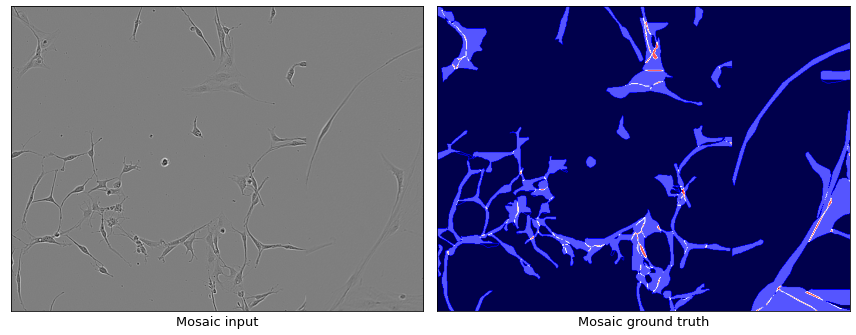

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

axs[0].imshow(image, cmap='gray')
axs[0].set_xlabel('Mosaic input', fontsize=13)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(np.sum(mask, -1), cmap='seismic')
axs[1].set_xlabel('Mosaic ground truth', fontsize=13)
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
merged = cv2.addWeighted(image[..., 0], 0.75, np.clip(np.sum(mask, -1).astype(image.dtype), 0, 1)*255, 0.25, 0.0,)
plt.imshow(merged, cmap='gray')

## Statistic processed time

In [ ]:
cort_annots = []
cort_df = sartorius_df[sartorius_df['cell_type'] == 'cort']
cort_ids = cort_df['id'].unique()

start = time.time()

for cort_id in tqdm(cort_ids):
    # Get random image and append current image
    mosaic_image_ids = np.random.choice(cort_ids, 1, replace=False)
    mosaic_image_ids = np.append(mosaic_image_ids, cort_id)
    
    mosaic_image, mosaic_mask = mosaic(mosaic_image_ids, SHAPE, seed=None)
    
    annot = []
    for idx in range(mosaic_mask.shape[-1]):
        annot.append(rle_encode(mosaic_mask[..., idx]))
        
    cort_annots += annot
    
end = time.time()

In [ ]:
process_time = round((end - start) / 60, 2)
print('It took {} minute(s) to applied mosaic (resize) over {} CORT images'.format(process_time, len(cort_ids)))

In [ ]:
astro_annots = []
astro_df = sartorius_df[sartorius_df['cell_type'] == 'astro']
astro_ids = astro_df['id'].unique()

start = time.time()

for astro_id in tqdm(astro_ids):
    # Get random image
    mosaic_image_ids = np.random.choice(astro_ids, 1, replace=False)
    mosaic_image_ids = np.append(mosaic_image_ids, astro_id)
    
    mosaic_image, mosaic_mask = mosaic(mosaic_image_ids, SHAPE, seed=None)
    
    annot = []
    for idx in range(mosaic_mask.shape[-1]):
        annot.append(rle_encode(mosaic_mask[..., idx]))
        
    astro_annots += annot
    
end = time.time()

In [ ]:
process_time = round((end - start) / 60, 2)
print('It took {} minute(s) to applied mosaic (resize) over {} ASTRO images'.format(process_time, len(astro_ids)))

In [ ]:
shsy5y_df = sartorius_df[sartorius_df['cell_type'] == 'shsy5y']
cort_df = sartorius_df[sartorius_df['cell_type'] == 'cort']

print('Number of instances of SHSY5Y: ', shsy5y_df.shape[0])
print('Number of instances of CORT: ', len(cort_annots))
print('Number of instances of ASTRO: ', len(astro_annots))

In [ ]:
print('Number of CORT instances of BEFORE AUGMENTING: ', cort_df.shape[0])
print('Number of CORT instances of AFTER AUGMENTING: ', len(cort_annots))

In [ ]:
print('CORT increases {} instances after augmenting'.format(len(cort_annots) - cort_df.shape[0]))

In [ ]:
print('Number of ASTRO instances of BEFORE AUGMENTING: ', astro_df.shape[0])
print('Number of ASTRO instances of after AUGMENTING: ', len(astro_annots))

In [ ]:
print('ASTRO increases {} instances after augmenting'.format(len(astro_annots) - astro_df.shape[0]))

In [ ]:
shsy5y_df.shape[0] / len(cort_annots)

In [ ]:
shsy5y_df.shape[0] / len(astro_annots)

In [ ]:
def rle2mask(rle, shape):
    array = np.fromiter(rle.split(), dtype=np.uint32)
    array = array.reshape(-1, 2)
    array[:, 0] = array[:, 0] - 1
    
    mask_decompressed = np.concatenate([np.arange(i[0], i[0] + i[1], 
                                                 dtype=np.uint32) for i in array])
    
    mask = np.zeros(SHAPE[0] * SHAPE[1], dtype=np.uint32)
    mask[mask_decompressed] = 1
    mask = mask.reshape(SHAPE)
    
    return mask

def get_box_height_width(rle, shape=SHAPE):
    mask = rle2mask(rle, shape)
    nonzero_coords = np.transpose(np.nonzero(mask))
    box_height = nonzero_coords[:, 0].max() - nonzero_coords[:, 0].min()
    box_width = nonzero_coords[:, 1].max() - nonzero_coords[:, 1].min()
    
    return box_height, box_width

Cort instance size



In [ ]:
cort_height_width = [get_box_height_width(rle) for rle in cort_annots]
cort_height_width = pd.DataFrame(cort_height_width)
cort_height_width.describe()

Astro instance size

In [ ]:
astro_height_width = [get_box_height_width(rle) for rle in astro_annots]
astro_height_width = pd.DataFrame(astro_height_width)
astro_height_width.describe()

In [ ]:
np.random.binomial(1, 0.5, size=3)

In [ ]:
stack_dict = {0: 'height', 1: 'width'}

In [ ]:
stack_dict

In [ ]:
stack_dict[1]

In [ ]:
stack_dict[0]